In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/infilatration.csv')

In [4]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [5]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])


In [9]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [13]:
selected_features_indices = selector.get_support(indices=True)


In [14]:
selected_feature_names = X.columns[selected_features_indices]


In [15]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Flow IAT Max', 'Fwd IAT Max',
       'Bwd IAT Total', 'Bwd IAT Max', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'act_data_pkt_fwd',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std',
       'Idle Max'],
      dtype='object')


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predictions
y_pred = rf_model.predict(X_test_selected)

In [18]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57673
           1       1.00      0.50      0.67         6

    accuracy                           1.00     57679
   macro avg       1.00      0.75      0.83     57679
weighted avg       1.00      1.00      1.00     57679

Confusion Matrix:
[[57673     0]
 [    3     3]]


In [19]:
# ROC Curve and AUC Score
y_prob = rf_model.predict_proba(X_test_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

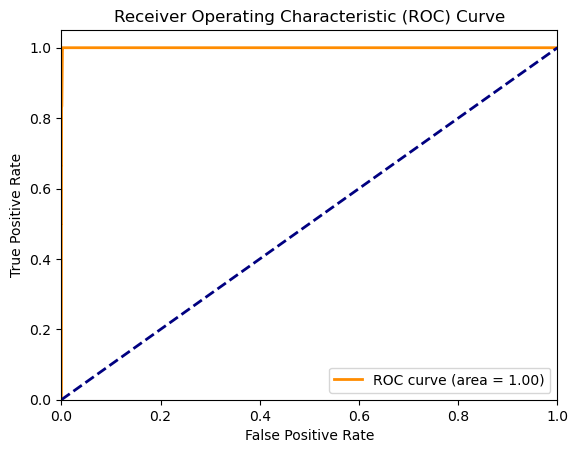

In [20]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

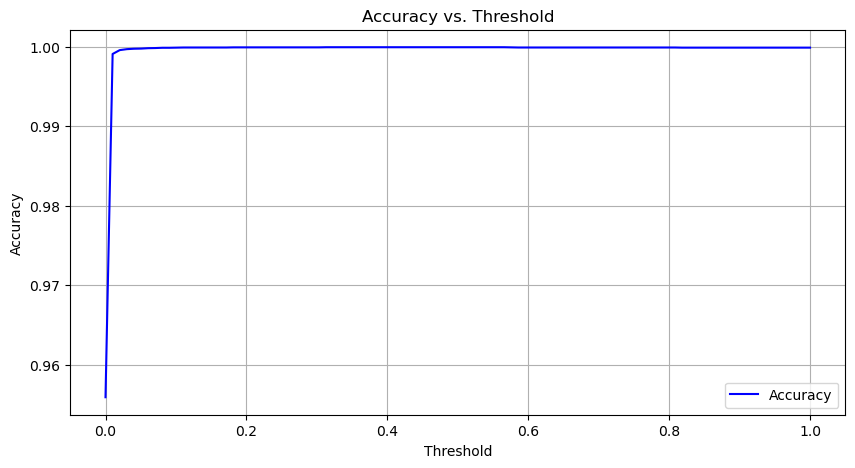

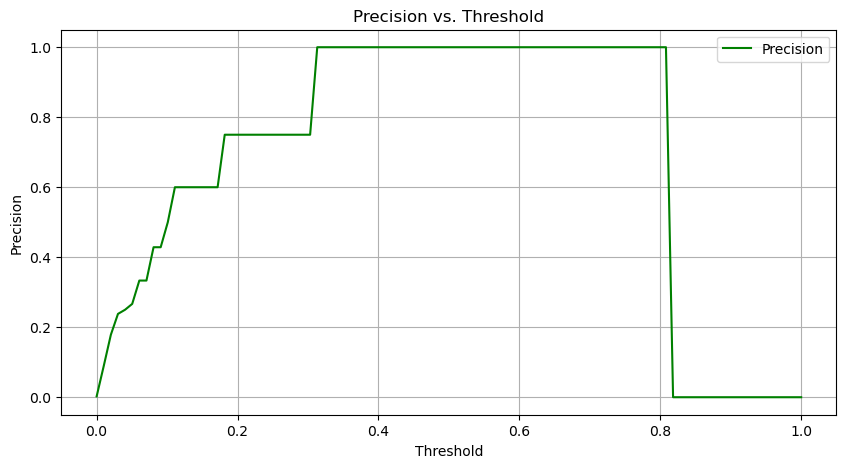

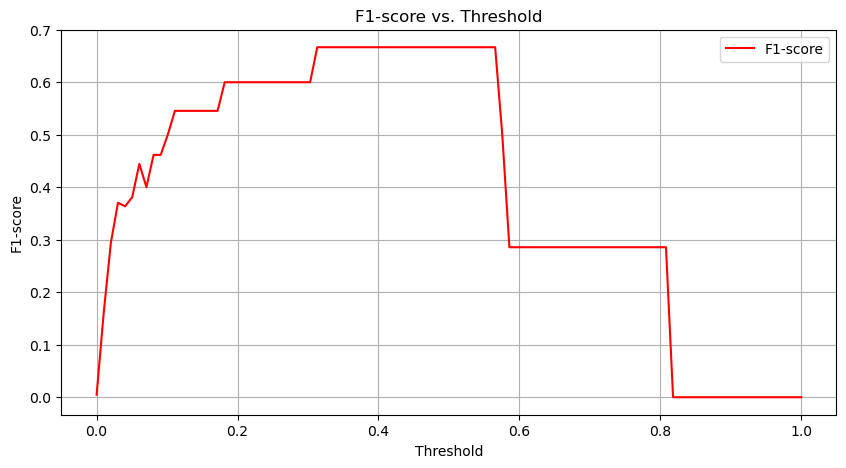

In [21]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np

# Compute accuracy, precision, and f1-score for different thresholds
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_thresholded))
    precisions.append(precision_score(y_test, y_pred_thresholded))
    f1_scores.append(f1_score(y_test, y_pred_thresholded))
    
    
# print('accuracies: ' + accuracy_score)
# print('precision: ' + precisions)
# print('F1: ' + accuracies)
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision', color='green')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-score
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score', color='red')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


accuracy: 0.9999479880025659
precision: 1.0
f1: 0.6666666666666666


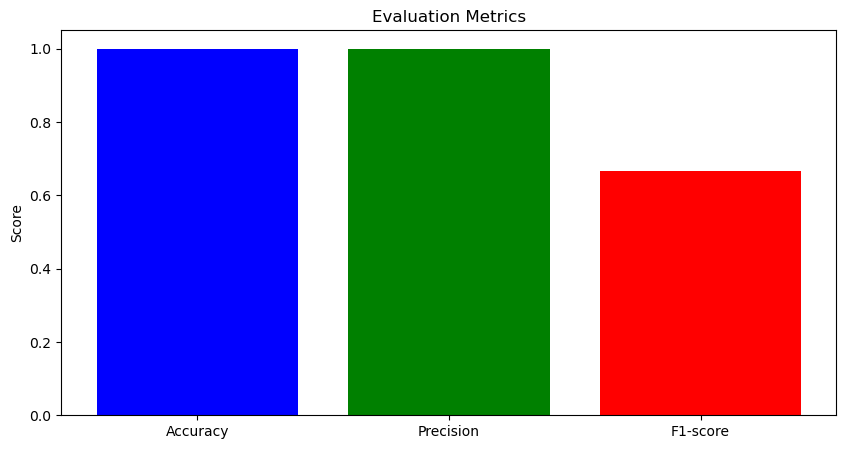

In [22]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Compute accuracy, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy: ' + str(accuracy))
print('precision: ' + str(precision))
print('f1: ' + str(f1))
# Plotting
metrics = ['Accuracy', 'Precision', 'F1-score']
values = [accuracy, precision, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()


Confusion Matrix:
[[57673     0]
 [    3     3]]


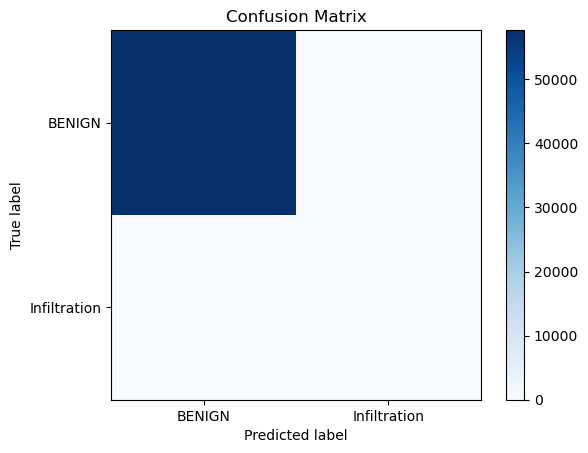

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'Infiltration'])
plt.yticks([0, 1], ['BENIGN', 'Infiltration'])
plt.show()

In [24]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 0
False Negatives: 3


In [25]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 57679


In [26]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 0.01%


In [28]:
import joblib
# Save the trained model to a file
joblib.dump(rf_model, 'random_forest_model_infiltration.pkl')

['random_forest_model_infiltration.pkl']